## Sentiment Analysis on Song Lyrics

In [1]:
import nltk
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 20000)

from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.text import Text

### Data cleaning

In [2]:
#read in data set
songs = pd.read_csv(".//data//lyrics.csv", index_col=0)

In [3]:
#check dimensions
songs.shape

(362237, 5)

In [4]:
#check column names
songs.columns

Index(['song', 'year', 'artist', 'genre', 'lyrics'], dtype='object')

In [5]:
#check different genres
songs['genre'].unique()

array(['Pop', 'Hip-Hop', 'Not Available', 'Other', 'Rock', 'Metal',
       'Country', 'Jazz', 'Electronic', 'Folk', 'R&B', 'Indie'],
      dtype=object)

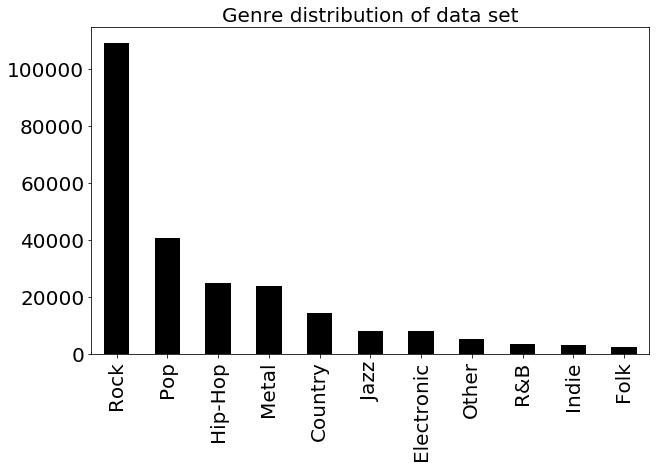

In [6]:
#drop rows without songtexts (i.e. labeled as 'instrumental')
songsWithLyrics = songs[songs['lyrics']!='instrumental'].dropna()
#drop rows with genre 'Not Available'
songsWithLyrics = songs[songs['genre']!='Not Available'].dropna()

#analyse the genres
genresN = songsWithLyrics['genre'].value_counts()

genresN.plot.bar(figsize=(10,6), fontsize=20, color='k')
plt.title('Genre distribution of data set', fontsize=20)
plt.show()

In [7]:
#keep Pop and Metal lyrics only
selectedSet = songsWithLyrics[songsWithLyrics['genre'].isin(['Pop', 'Metal'])]

#final check
selectedSet['genre'].unique()

array(['Pop', 'Metal'], dtype=object)

In [8]:
#split up into genre set
pop = selectedSet[selectedSet['genre']=='Pop']
metal = selectedSet[selectedSet['genre']=='Metal']

pop.shape, metal.shape

((40466, 5), (23759, 5))

In [9]:
#Find artists with the most entries:
pop_artists = []
for artist, subset in pop.groupby('artist'):
    pop_artists.append([len(subset), artist])
pop_artists = sorted(pop_artists, reverse=True)

metal_artists = []
for artist, subset in metal.groupby('artist'):
    metal_artists.append([len(subset), artist])
metal_artists = sorted(metal_artists, reverse=True)

#Ten artists with the most entries
pop_artists = pop_artists[:10]
metal_artists = metal_artists[:10]

#Get artist names and sort them
pop_set = []
for cnt, artist in pop_artists:
    pop_set.append(artist)
pop_set = sorted(pop_set)

metal_set = []
for cnt, artist in metal_artists:
    metal_set.append(artist)
metal_set = sorted(metal_set)

#pop_artists, metal_artists, pop_set, metal_set

In [10]:
pop_final = pop[pop['artist'].isin(pop_set)]
metal_final = metal[metal['artist'].isin(metal_set)]

#pop_final.artist.unique(), metal_final.artist.unique()

In [11]:
pop_final.shape, metal_final.shape

((4245, 5), (1794, 5))

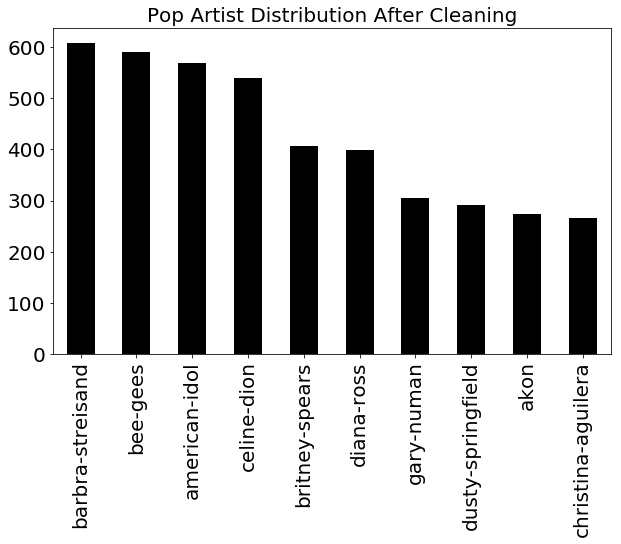

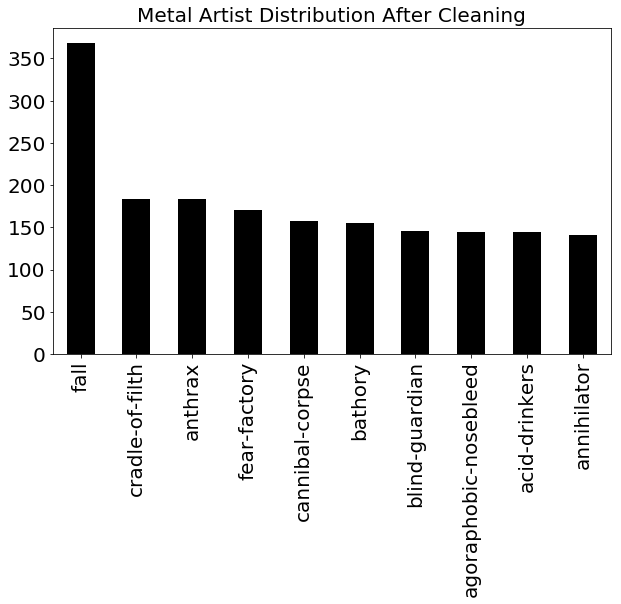

In [12]:
#plot data of new sets
plot_data = pop_final['artist'].value_counts()
plot_data.plot.bar(figsize=(10,6), fontsize=20, color='k')
plt.title('Pop Artist Distribution After Cleaning', fontsize=20)
plt.show()

plot_data = metal_final['artist'].value_counts()
plot_data.plot.bar(figsize=(10,6), fontsize=20, color='k')
plt.title('Metal Artist Distribution After Cleaning', fontsize=20)
plt.show()

### Data Processing and Analysis

Some of the processing methods have been adapted from https://kvsingh.github.io/lyrics-sentiment-analysis.html

In [13]:
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer

#initialize stopwords
customStopWords = ["'s", "n't", "'m", "'re", "'ll","'ve","...", "ä±", "''", '``',\
                  '--', "'d", 'el', 'la', 'na', 'ya', 'yo', 'oh', 'ca']
stopWords = stopwords.words('english') + customStopWords

#### Pop Music

In [14]:
pop_words = ""

for lyric in pop_final.iterrows():
    pop_words += " " + lyric[1]['lyrics']
    
pop_words = nltk.word_tokenize(pop_words.lower())
#Remove stopwords and numeric characters
pop_words = [ word for word in pop_words if len(word) > 1\
                             and not word.isnumeric()\
                             and word not in stopWords ]
word_dist = FreqDist(pop_words)

plot_data = []
print("The 10 most common words in the pop dataset are :")
for word, frequency in word_dist.most_common(10):
    print( u'{} : {}'.format( word, frequency ) )
    plot_data.append([word, frequency])

The 10 most common words in the pop dataset are :
love : 10734
know : 6451
got : 5532
like : 5273
baby : 5069
get : 4103
one : 3925
see : 3913
let : 3709
want : 3658


In [15]:
vals = []
wrds = []
for word, val in plot_data:
    vals.append(val)
    wrds.append(word)
    
#vals, wrds

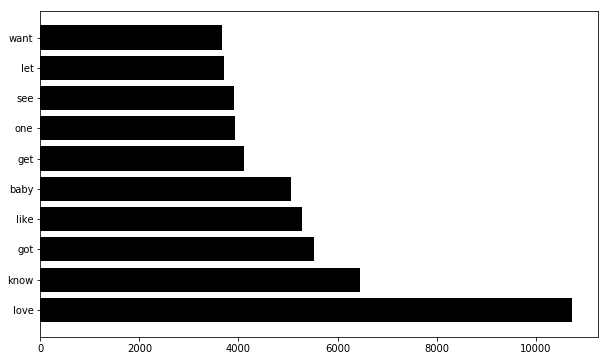

In [16]:
plt.figure(figsize=(10,6))
plt.barh(np.arange(10), vals, color='k')
plt.yticks(np.arange(10), wrds)
plt.show()

#### Metal Music

In [17]:
metal_words = ""

for lyric in metal_final.iterrows():
    metal_words += " " + lyric[1]['lyrics']
    
metal_words = nltk.word_tokenize(metal_words.lower())
#Remove stopwords and numeric characters
metal_words = [ word for word in metal_words if len(word) > 1\
                             and not word.isnumeric()\
                             and word not in stopWords ]
word_dist = FreqDist(metal_words)

plot_data = []
print("The 10 most common words in the metal dataset are :")
for word, frequency in word_dist.most_common(10):
    print( u'{} : {}'.format( word, frequency ) )
    plot_data.append([word, frequency])

The 10 most common words in the metal dataset are :
one : 1224
like : 1185
life : 997
time : 943
see : 856
never : 811
man : 761
know : 754
blood : 687
take : 686


In [18]:
vals = []
wrds = []
for word, val in plot_data:
    vals.append(val)
    wrds.append(word)
    
#vals, wrds

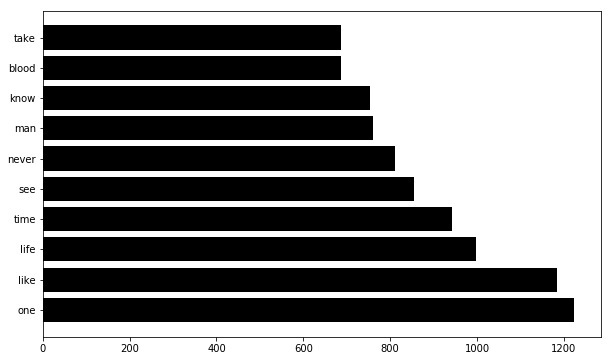

In [19]:
plt.figure(figsize=(10,6))
plt.barh(np.arange(10), vals, color='k')
plt.yticks(np.arange(10), wrds)
plt.show()

### Sentiment Analysis

In [20]:
def lyrics2flat(lyrics):
    return lyrics.split("\n")

#### Pop

In [30]:
###Adapted from https://kvsingh.github.io/lyrics-sentiment-analysis.html
nltk.download('vader_lexicon')

emo = pd.DataFrame(columns = ('artist', 'pos', 'neu', 'neg'))
sia = SentimentIntensityAnalyzer()

pop_final['flatlyrics'] = pop_final.lyrics.map(lyrics2flat)
pop_final.head(1)   #test whether lyrics flattening worked

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Nightsung\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\Nightsung\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,song,year,artist,genre,lyrics,flatlyrics
index,,,,,,
159151,don-t-let-me-be-the-last-to-know,2009,britney-spears,Pop,"My friends say you're so into me\nAnd that you need me desperately\nThey say you say we're so complete\nBut I need to hear it straight from you\nIf you want me to believe it's true\nI've been waiting for so long it hurts\nI want to hear you say the words, please\nDon't, don't let me be the last to know\nDon't hold back, just let it go\nI need to hear you say\nYou need me all the way\nOh, if you love me so\nDon't let me be the last to know\nOoh yeah, baby\nYour body language says so much\nYeah, I feel it in the way you touch\nBut 'til you say the words it's not enough\nCome on and tell me you're in love, please\nDon't, don't let me be the last to know\nDon't hold back, just let it go\nI need to hear you say\nYou need me all the way\nOh, if you love me so\nDon't let me be the last to know\nCome on baby, come on darling, ooh yeah\nCome on, let me be the one\nCome on now, oh yeah\nI need to hear you say (I need to hear you say)\nYou love me all the way (you love me all the way)\nAnd I don't want to wait another day\nI want to feel the way you feel\nOh, come on\nDon't, (don't) don't let me be the last to know (just let me be the one)\nDon't (don't) hold back (hold back), just let it go (just let it go)\nI need to hear you say (I need to hear you say)\nYou need me all the way (you need me all the way)\nSo, baby, if you love me\nDon't let me be the last to know","[My friends say you're so into me, And that you need me desperately, They say you say we're so complete, But I need to hear it straight from you, If you want me to believe it's true, I've been waiting for so long it hurts, I want to hear you say the words, please, Don't, don't let me be the last to know, Don't hold back, just let it go, I need to hear you say, You need me all the way, Oh, if you love me so, Don't let me be the last to know, Ooh yeah, baby, Your body language says so much, Yeah, I feel it in the way you touch, But 'til you say the words it's not enough, Come on and tell me you're in love, please, Don't, don't let me be the last to know, Don't hold back, just let it go, I need to hear you say, You need me all the way, Oh, if you love me so, Don't let me be the last to know, Come on baby, come on darling, ooh yeah, Come on, let me be the one, Come on now, oh yeah, I need to hear you say (I need to hear you say), You love me all the way (you love me all the way), And I don't want to wait another day, I want to feel the way you feel, Oh, come on, Don't, (don't) don't let me be the last to know (just let me be the one), Don't (don't) hold back (hold back), just let it go (just let it go), I need to hear you say (I need to hear you say), You need me all the way (you need me all the way), So, baby, if you love me, Don't let me be the last to know]"


In [34]:
i=0
for artist in pop_final['artist'].unique():
    print(type(artist), artist)
    pos = 0
    neu = 0
    neg = 0
    
    artist_set = pop_final[pop_final['artist'] == artist]
    
    for lyrics in artist_set['flatlyrics']:
        for sentence in lyrics:
            comp = sia.polarity_scores(sentence)
            comp = comp['compound']
            
            if comp >= 0.5:
                pos += 1
            elif comp > -0.5 and comp < 0.5:
                neu += 1
            else:
                neg += 1
    
    total = neg + neu + pos
    percent_neg = (neg/float(total))*100
    percent_neu = (neu/float(total))*100
    percent_pos = (pos/float(total))*100
    emo.loc[i] = (artist, percent_pos, percent_neu, percent_neg)
    i+=1
#emo.shape

<class 'str'> britney-spears
<class 'str'> bee-gees
<class 'str'> celine-dion
<class 'str'> dusty-springfield
<class 'str'> gary-numan
<class 'str'> barbra-streisand
<class 'str'> american-idol
<class 'str'> akon
<class 'str'> christina-aguilera
<class 'str'> diana-ross


(10, 4)

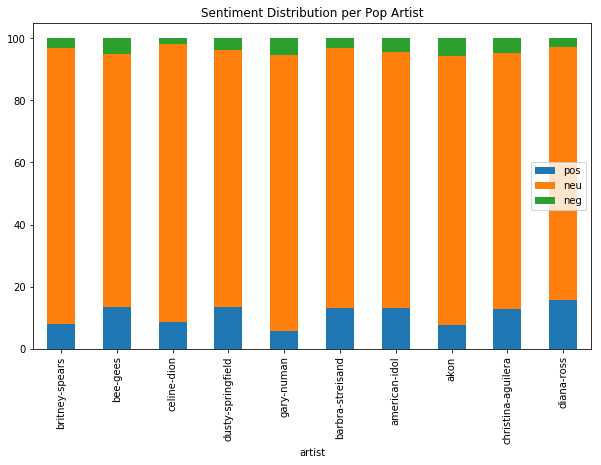

,artist,pos,neu,neg
0,britney-spears,8.008808,88.671099,3.320093
1,bee-gees,13.383459,81.674877,4.941665
2,celine-dion,8.646436,89.605840,1.747723
3,dusty-springfield,13.386594,82.687062,3.926345
4,gary-numan,5.887522,88.766842,5.345636
5,barbra-streisand,13.166927,83.707748,3.125325
6,american-idol,13.271267,82.356700,4.372034
7,akon,7.520481,86.668238,5.811281
8,christina-aguilera,12.728858,82.460173,4.810969
9,diana-ross,15.692777,81.368973,2.938250


In [40]:
emo.plot.bar(figsize=(10,6), x='artist', stacked=True)
plt.title('Sentiment Distribution per Pop Artist')
plt.show()

emo

#### Metal

In [41]:
emo_metal = pd.DataFrame(columns = ('artist', 'pos', 'neu', 'neg'))

metal_final['flatlyrics'] = metal_final.lyrics.map(lyrics2flat)
metal_final.head(1)   #test whether lyrics flattening worked

C:\Users\Nightsung\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,song,year,artist,genre,lyrics,flatlyrics
index,,,,,,
22210,symphonies-of-doom,2007,blind-guardian,Metal,"In the dark night, they defend their missiles\nWhere it's the night we all die\nEnthralling power, who searches to be masters\nThey play their game with your life\nThe burning fire comes around, the heat is on\nJust for this day, it's all sad blues\nThe East sun is burning hard\nSee, your life is short\nSee the rainbow in the mirror\nSee the rainbow in the sky\nSee the desert in front of you\nSee the desert of life\nStanding in the cold rain, waiting for the end\nSee the shadows of the night\nI have told you, but now it is too late\nThese are symphonies of doom\nFeel the danger, this final battle\nIt will imply us all God's agony\nThe endless blitzes just blind your eyes shut\nAnd blow your life out to nothingness\nBlack shadows storming in the East, but you can't see\nThe liec has set that power free\nThe East sun is burning hard\nSee, the life is short\nSee the rainbow in the mirror\nSee the rainbow in the sky\nSee the desert in front of you\nSee the desert of life\nI'm no sinner, I'm no fool\nI have heard these chants before\nI have told you but now it is too late\nThese are symphonies of doom","[In the dark night, they defend their missiles, Where it's the night we all die, Enthralling power, who searches to be masters, They play their game with your life, The burning fire comes around, the heat is on, Just for this day, it's all sad blues, The East sun is burning hard, See, your life is short, See the rainbow in the mirror, See the rainbow in the sky, See the desert in front of you, See the desert of life, Standing in the cold rain, waiting for the end, See the shadows of the night, I have told you, but now it is too late, These are symphonies of doom, Feel the danger, this final battle, It will imply us all God's agony, The endless blitzes just blind your eyes shut, And blow your life out to nothingness, Black shadows storming in the East, but you can't see, The liec has set that power free, The East sun is burning hard, See, the life is short, See the rainbow in the mirror, See the rainbow in the sky, See the desert in front of you, See the desert of life, I'm no sinner, I'm no fool, I have heard these chants before, I have told you but now it is too late, These are symphonies of doom]"


In [42]:
i=0
for artist in metal_final['artist'].unique():
    print(type(artist), artist)
    pos = 0
    neu = 0
    neg = 0
    
    artist_set = metal_final[metal_final['artist'] == artist]
    
    for lyrics in artist_set['flatlyrics']:
        for sentence in lyrics:
            comp = sia.polarity_scores(sentence)
            comp = comp['compound']
            
            if comp >= 0.5:
                pos += 1
            elif comp > -0.5 and comp < 0.5:
                neu += 1
            else:
                neg += 1
    
    total = neg + neu + pos
    percent_neg = (neg/float(total))*100
    percent_neu = (neu/float(total))*100
    percent_pos = (pos/float(total))*100
    emo_metal.loc[i] = (artist, percent_pos, percent_neu, percent_neg)
    i+=1
emo_metal.shape

<class 'str'> blind-guardian
<class 'str'> fall
<class 'str'> agoraphobic-nosebleed
<class 'str'> fear-factory
<class 'str'> annihilator
<class 'str'> acid-drinkers
<class 'str'> cannibal-corpse
<class 'str'> cradle-of-filth
<class 'str'> anthrax
<class 'str'> bathory


(10, 4)

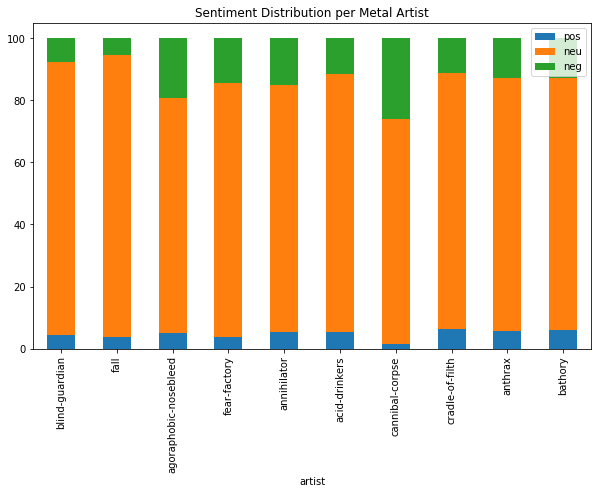

,artist,pos,neu,neg
0,blind-guardian,4.253952,87.893587,7.852461
1,fall,3.870816,90.553644,5.575540
2,agoraphobic-nosebleed,5.167598,75.558659,19.273743
3,fear-factory,3.834132,81.767035,14.398833
4,annihilator,5.339670,79.396142,15.264188
5,acid-drinkers,5.420737,83.075953,11.503309
6,cannibal-corpse,1.408674,72.649573,25.941754
7,cradle-of-filth,6.201236,82.521025,11.277738
8,anthrax,5.531499,81.729292,12.739209
9,bathory,5.862534,81.424079,12.713387


In [43]:
emo_metal.plot.bar(figsize=(10,6), x='artist', stacked=True)
plt.title('Sentiment Distribution per Metal Artist')
plt.show()

emo_metal